In [1538]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model
import numpy as np
import matplotlib.pyplot as plt
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice

In [1539]:
@partial(jit, static_argnums=(0,2,3, 5, 6,7 ))
def run(cbm, time_out, oversample,production, y0=None, args=(), target_C_14=None, steady_state_production=None):
        @jit
        def derivative(y, t):
            ans = jnp.matmul(cbm._matrix, y)
            production_rate_constant = production(t, *args)
            production_rate_constant = cbm._convert_production_rate(production_rate_constant)
            production_term = cbm._production_coefficients * production_rate_constant
            return ans + production_term

        time_out = jnp.array(time_out)
        time_values = jnp.linspace(jnp.min(time_out) - 1, jnp.max(time_out) + 1, (time_out.shape[0] + 1) * oversample)
        solution = None
        if y0 is not None:
            y_initial = jnp.array(y0)
        else:
            if steady_state_production is not None:
                solution = cbm.equilibrate(production_rate=steady_state_production)

            elif target_C_14 is not None:
                solution = cbm.equilibrate(production_rate=cbm.equilibrate(target_C_14=target_C_14))
            else:
                ValueError("Must give either target C-14 or production rate.")
            y_initial = jnp.array(solution)

        if not callable(production):
            raise ValueError("incorrect object type for production")

        states = odeint(derivative, y_initial, time_values)
        return states, solution


In [1540]:
@partial(jit, static_argnums=(0,2))
def bin_data(cbm, data, time_oversample, time_out, growth=jnp.ones((12,))):
    masked = jnp.linspace(0, 1, time_oversample)
    kernel = (masked < 0.5)
    shifted_index = cond(growth[0] == 0, lambda x: 9, lambda x: 3, growth)
#         print(shifted_index)
        
#         predict_batch_f = jax.vmap(partial(rebin, time_out, shifted_index, time_oversample//12, kernel),
#                                    in_axes=1, out_axes=1)
#         binned_data = predict_batch_f(states)
    binned_data = rebin1D(cbm, time_out, shifted_index, time_oversample, kernel, data)
    return binned_data

#         return binned_data
@partial(jit, static_argnums=(2))
def rebin_vmap(time_out, shifted_index, oversample, kernel, s):
    predict_batch_f = jax.vmap(partial(rebin1D, time_out, shifted_index, oversample, kernel),
                                   in_axes=1, out_axes=1)
    binned_data = predict_batch_f(s)
    return binned_data

# @partial(jit, static_argnums=(2))
def rebin_vect(time_out, shifted_index, oversample, kernel, s):    
#     new_data = jnp.zeros(s.shape)
# #     tiled_full = jnp.tile(kernel, (time_out.shape[0] + 1))
#     new_thing = jnp.array(jax.lax.dynamic_slice(s, (shifted_index*oversample,), (s.shape[0],)))
# #     mask = jnp.arange(s.shape[0]) >= shifted_index*oversample
#     new_data = jax.lax.dynamic_update_slice(new_data, new_thing, (0,))
#     states = jnp.multiply(kernel, s)
#     print((states.shape[0] // (12*oversample), 12*oversample))
#     binned  = ((jnp.reshape(s, (s.shape[0] // (12*oversample), 12*oversample)) * kernel).sum(1) / jnp.sum(kernel))[:-1]
#     binned_data = (jnp.reshape(states, (states.shape[0] // (12*oversample), 12*oversample)).sum(1) / jnp.sum(kernel)*len(time_out))[:-1]
    return binned
#     time_values = jnp.linspace(jnp.min(time_out) - 1, jnp.max(time_out) + 1, (time_out.shape[0] + 1) * oversample)
#     digitized = jnp.digitize(time_values,time_out - shifted_index/12)
#     th = jnp.zeros(time_out.shape)
#     for i in range(1, len(time_out) + 1):
#         mask = (digitized == i)
#         chunk = jax.lax.dynamic_slice(s, ((i+1)*oversample*12 - shifted_index * oversample,), (oversample*12,))
#         th = jax.lax.dynamic_update_slice(th, jnp.array([(jnp.where(mask, s, 0).mean())]), (i,))
        



@partial(jit, static_argnums=(2))
def rebin_matrix(time_out, shifted_index, oversample, kernel, s):
    matrix = jnp.zeros((s.shape[0], len(time_out)))
    kernel = jnp.reshape(kernel, (oversample*12, 1)).astype(float)
#     matrix = jnp.array([[0] * (i+1)*oversample*12 - shifted_index * oversample + kernel + [0] * len(s.shape[0])-  for i in range(len(time_out))])
#     matrix = jax.lax.fori_loop(0, len(time_out), lambda i,x:  jax.lax.dynamic_update_slice(matrix, kernel, ((i+1)*oversample*12 - shifted_index * oversample,i)), matrix)
    for i in range(len(time_out)):
        matrix = jax.lax.dynamic_update_slice(matrix, kernel, ((i+1)*oversample*12 - shifted_index * oversample,i))
#     matrix = sparse.BCOO.fromdense(matrix)
    binned = jnp.transpose(matrix) * s
    binned = jnp.sum(binned, axis=1)/jnp.sum(kernel)
    return binned
    
    
# (jnp.reshape(states, (-1, states.shape[0] // time_oversample, time_oversample, states.shape[1]))\
#                        .sum(2).sum(0) / jnp.sum(tiled))[:-2, :]
@partial(jit, static_argnums=(2))
def rebin(time_out, shifted_index, oversample, kernel, s):
    binned_data = jnp.zeros((len(time_out), s.shape[1]))
    for i in range(len(time_out)):
        for j in range(s.shape[1]):
            chunk = jax.lax.dynamic_slice(s, ((i+1)*oversample*12 - shifted_index * oversample,j), (oversample*12,1))
#             chunk = s[(i+1)*oversample*12 - shifted_index * oversample: (i + 2)*oversample*12 - shifted_index* oversample, j]
            binned_data = binned_data.at[i,j].set(jnp.sum(jnp.multiply(chunk, kernel)) / (jnp.sum(kernel)))
    return binned_data
            
        
def rebin2D(time_out, shifted_index, oversample, kernel, s):
    data = jnp.zeros((len(time_out), s.shape[1]))
    for i in range(s.shape[1]):
        data1D = rebin1D(time_out, shifted_index, oversample, kernel, s[:,i])
        data = data.at[:,i].set(data1D)
    return data
            
# def fori_loop(lower, upper, body_fun, init_val):
#   val = init_val
#   for i in range(lower, upper):
#     val = body_fun(i, val)
#   return val
# jax.lax.fori_loop(lower, upper, body_fun, init_val)

@partial(jit, static_argnums=(0,3))
def rebin1D(cbm, time_out, shifted_index, oversample, kernel, s):
    binned_data = jnp.zeros((len(time_out), ))
#     fun = lambda i, val: dynamic_update_slice(val, jnp.array([jnp.sum(jnp.multiply(dynamic_slice(
#             s, ((i + 1) * oversample * 12 - shifted_index * oversample,), (oversample * 12,)), kernel)) / (
#                                                                               jnp.sum(kernel))]), (i,))
    binned_data = fori_loop(0, len(time_out), lambda i, val: dynamic_update_slice(val, jnp.array([jnp.sum(jnp.multiply(dynamic_slice(
            s, ((i + 1) * oversample - shifted_index * oversample//12,), (oversample,)), kernel)) / (
                                                                              jnp.sum(kernel))]), (i,)), binned_data)

    return binned_data





In [1541]:
cbm = load_presaved_model('Brehm21', production_rate_units='atoms/cm^2/s')
cbm.compile()


In [1542]:
start = 760
resolution = 1000
burn_in_time = np.linspace(760 - 1000, 760, resolution)
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
burn_in_solutions = cbm.equilibrate(production_rate=steady_state_burn_in)
d_14_time_series_fine = np.linspace(760, 788, 2700)
d_14_time_series_coarse = np.arange(760, 788)



def sg(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.88349 * duration)) ** 8.)


def miyake_event(t, start_time, duration, phase, area):
    height = sg(t, start_time, duration, area)
    prod = steady_state_burn_in + 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod

In [1543]:
burn_in, _ = run(cbm, burn_in_time, 108, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12),
                     y0=burn_in_solutions)
prod = miyake_event(d_14_time_series_fine, 775, 1 / 12, np.pi / 2, 81 / 12)
event, _ = run(cbm, d_14_time_series_coarse, 108, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12),
                   y0=burn_in[-1, :])

In [1544]:
masked = jnp.linspace(0, 1, 108)
kernel = (masked < 0.5)
# for i in range(len(d_14_time_series_coarse)):
#     matrix = jax.lax.dynamic_update_slice(matrix, kernel, ((i+1)*996 - 3 * 996//12,i))
    
# matrix2 = jnp.zeros((28884, len(d_14_time_series_coarse)))
# for i in range(len(d_14_time_series_coarse)):
#     matrix2 = jax.lax.dynamic_update_slice(matrix2, kernel, ((i+1)*996 - 9 * 996//12,i))
kernel_full = jnp.tile(kernel, (len(d_14_time_series_coarse) + 1))

In [1545]:
# %%timeit
vals = bin_data(cbm, event[:,1],108,d_14_time_series_coarse,growth=jnp.array([1,1,1,0,0,0,0,0,0,1,1,1]))


# 1.3 ms by passing in mask

vals2 = rebin_data(cbm, event[:,1],108,d_14_time_series_coarse,growth=jnp.array([0,0,0,1,1,1,1,1,1,0,0,0]))
# d_14_c = run_D_14_C_values(cbm, d_14_time_series_coarse, 996, production=miyake_event,
#                                args=(775, 1 / 12, np.pi / 2, 81 / 12),
#                                y0=burn_in[-1, :], steady_state_solutions=burn_in_solutions, 
#                            growth='south')


# cbm.define_growth_season(['october', 'november', 'december', 'january', 'february', 'march'])
# cbm.compile()
# burn_in2, _ = run(cbm, burn_in_time, production=miyake_event, args=(775, 1 / 12,  np.pi / 2, 81 / 12),
#                       y0=burn_in_solutions)
# d_14_c2 = run_D_14_C_values(cbm,d_14_time_series_coarse, 996, production=miyake_event,
#                                 args=(775, 1 / 12, np.pi/2, 81 / 12),
#                                 y0=burn_in2[-1, :], steady_state_solutions=burn_in_solutions, 
#                             growth='north')

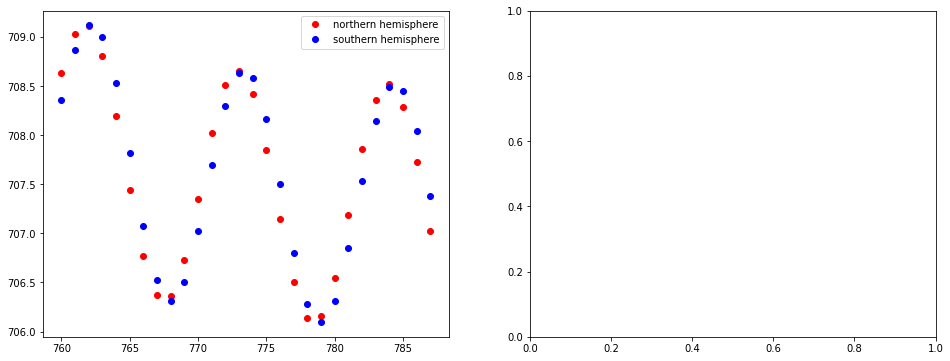

In [1546]:
# vals = [-21.63, -22.28, -22.64, -23.83, -22.20, -22.99, -20.73, -21.59, -25.32, -25.6, -25.70, -24.00, -23.73,
#         -21.91, -23.44, -9.335, -6.46, -9.70, -11.17, -10.31, -11.10, -10.72, -10.67, -8.63, -9.68, -9.31,
#         -12.33, -14.44]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.0, 6.0))


ax1.plot(d_14_time_series_coarse, vals, 'ro')
ax1.plot(d_14_time_series_coarse, vals2, 'bo')
# ax1.plot(d_14_time_series_coarse, d_14_c - 22.64846153846154, 'bo')
# ax1.plot(d_14_time_series_coarse, d_14_c2 - 22.64846153846154, 'go')

ax1.legend(["northern hemisphere", "southern hemisphere"])
# ax2.plot(d_14_time_series_fine, event[:, 1], 'ro')
# a = 774.75
# plt.axvline(a)
# plt.axvline(a + 0.5)
# plt.axvline(a + 1)
# # # ax2.set_ylim(0,5)
# # ax2.set_xlim(774, 776)

plt.ticklabel_format(useOffset=False)

plt.show()